# DTM model (paragraphs as input)

In [1]:
#System
import os
import sys
from tqdm import tqdm 

#Data structure manipulation
import pandas as pd
import numpy as np

#text cleaning 
import re
import string

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#gensim
import gensim
from gensim import corpora
from gensim.test.utils import datapath
from gensim.models import ldaseqmodel
from gensim.test.utils import datapath
from gensim.models.wrappers.dtmmodel import DtmModel

# unlist nested lists
from itertools import chain

# count word frequencies
from collections import defaultdict

# vizualization
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

# timer function
import time

## Reading the data

In [4]:
#Path to where the raw text files are stored within the session folders, i.e, converted sessions.
origin_path = "C:/DATA/convSes"

In [2]:
#A function for reading in the speeches
def read_text(file_path, file):
    
    '''Reading the text files'''
    
    with open(file_path, 'r', encoding='utf-8') as file:
        doc=file.read()
    return doc

In [5]:
#Bringing in all the speeches
doc_set = []
for i in range (0,50):
    year = 1970 + i
    session = "session " + str(25+i)+ " - "  + str(year)
    data_path = f"{origin_path}\\{session}"
    os.chdir(data_path)
    for file in os.listdir():
        if file[-4:]=='.txt':
            file_path = f"{data_path}\\{file}"
            doc_set.append({'Year': year, 'ISO_Code': file[:3] , 'text': read_text(file_path, file)})
        else:
            print(file)
            pass

word2vec.model
Session 74 - 2019 - Shortcut.lnk


In [6]:
columns=['Year', 'ISO_Code', 'text']
dataset = pd.concat([pd.DataFrame([i], columns=columns) for i in tqdm(doc_set)], ignore_index=True)
dataset.head()

100%|██████████| 8288/8288 [00:04<00:00, 1915.89it/s]


,Year,ISO_Code,text
0,1970,ALB,33: May I first convey to our President the co...
1,1970,ARG,177.\t : It is a fortunate coincidence that pr...
2,1970,AUS,100.\t It is a pleasure for me to extend to y...
3,1970,AUT,155.\t May I begin by expressing to Ambassado...
4,1970,BEL,"176. No doubt each of us, before coming up to ..."


**Creating subset including only the G20 states**

In [7]:
# only select states belonging to the G20 group (minus south afrika and EU representatives)
g20 =  dataset.ISO_Code.isin(['CAN','FRA', 'DEU', 'USA', 'GBR', 'ITA', 'JPN','ARG', 'Aus', 'BRA', 'IND', 'IDN', 
                        'CAN', 'MEX', 'RUS', 'SAU', 'KOR', 'TUR', 'CHN'])
G20 = dataset[g20]

# reset ascending index for subset dataset
G20.reset_index(inplace = True, drop = True)
G20.head()

,Year,ISO_Code,text
0,1970,ARG,177.\t : It is a fortunate coincidence that pr...
1,1970,BRA,"1.\tMr. President, I should like, first of all..."
2,1970,CAN,The General Assembly is fortunate indeed to ha...
3,1970,FRA,"84.\t Within one month, when we celebrate the..."
4,1970,GBR,"110.\t Mr. President, I should like first to s..."


In [8]:
# testing a random sample of speeches
G20.sample(10)

,Year,ISO_Code,text
664,2011,CAN,"Nearly 66 years ago, in \n1946, one of my pred..."
515,2002,BRA,"I congratulate you, Sir, on\nyour election to ..."
93,1976,CHN,"We, the delegation of the People's Republic of..."
110,1977,DEU,"﻿91.\t Mr. President, I should like first on b..."
228,1984,MEX,﻿87. On behalf of the Government of Mexico and...
408,1995,KOR,"Mr.\nPresident, congratulations on your assump..."
757,2016,RUS,"Last year, from this same rostrum, at the seve..."
170,1981,BRA,"Sir, as the first speaker in the general debat..."
702,2013,IDN,Let me begin by \ncongratulating His Excellenc...
458,1998,MEX,The election of the Minister for Foreign Affai...


**Split speeches into paragraphs**

In [9]:

# Split speeches by delimiter \n and...
# ...stack a new row for each paragraph to dataframe... 
# ...with context info from corresponding speech.

temporary_file = G20['text'].str.split('\.\s?\s?\s?\n', expand=True).stack().reset_index(level=0)
temporary_file.rename(columns={'level_0': 'speech_index', 0: 'text'}, inplace=True)
# temporary_file.reset_index().drop('index',1)

# merge context info from speeches with texts of paragraphs
G20 = G20.drop('text', 1) # drop original text column
G20 = temporary_file.merge(G20, right_index=True, left_on='speech_index', how='outer')

# reorder columns in new datset
G20['paragraph_index'] = np.arange(len(G20))
cols = G20.columns.tolist()
cols = cols[-1:] + cols[:-1]
G20 = G20[cols].set_index('paragraph_index')
G20 = G20[1:]

## Pre-processing

**Defining/loading in the needed functions --> can we do this in a cleaner way??**

In [10]:
nlp = spacy.load('en_core_web_lg')#run in conda to download the library --> python -m download en_core_web_lg 

In [11]:
def init_proc(text, stop_words=[]):
    
    '''Pre-processing the input in single list'''
    
    stops = stopwords.words("english")
    stops.extend(stop_words)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\-', ' ', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub(r'[0-9]+','', text)
    text = re.sub(r'[^\w\s]', '', text)
    lower = text.lower()
    doc = nlp(lower)
    words = []
    for token in doc:
        lemma = token.lemma_
        if lemma not in stops:
                words.append(lemma)
    return words

In [12]:
stop_words =['general', 'assembly', 'conference', 'session', 'congratulations', 
             'congratulate', 'secretarygeneral','members', 'member', 'united', 'nations', 
             'nation', 'statement', 'honour','every', 'sir', 'majesty', 'president', 
             'minister', 'prime', 'ambassador', 'thank', 'thanks', 'world', 'international', 
             'states', 'we', 'us', 'they', 'system', 'organization','say', 'think', 'know', 
             'want', 'need', 'let', 'ask', 'go', 'look', 'stand', 'open', 'give', 'see', 'come', 
             'make', 'made', 'meet','act', 'use', 'take', 'bring', 'ensure', 'able', 'assume', 
             'continue', 'change', 'progress', 'process', 'year', 'years', 'time', 'today',  
             'would', 'will', 'might', 'together', 'common', 'future', 'one', 'order', 'end', 
             'new', 'necessary', 'major', 'minor', 'many', 'people', 'peoples', 'appropriate', 
             'historic', 'adequate', 'best', 'better', 'confident', 'important', 'special',
             'great', 'therefore', 'thus', 'hence', 'like', 'particularly', 'many', 'much', 
             'greater', 'especially', 'towards', 'always', 'whether', 'around',
             'possible', 'clear', 'simply', 'must', 'also', 'however', 'mr',
             'united', 'kingdom', 'great', 'britain', 'france', 'germany','italy', 'japan',
             'canada', 'usa', 'argentina', 'australia', 'china', 'brazil', 'india', 'indonesia',  
             'mexico', 'russia', 'saudi', 'arabia', 'south', 'korea', 'turkey','liechtenstein',
             'I', ' ', '  ', 'still','could','may','thirdly','elsewhere','yet','ever','since','welcome',
             'npt','among','non', 'secretary_kofi_annan','behalf','sixty', 'sixtieth']

In [13]:
#loading the bigram models from the bigram_trigram_model_notebooks
#temp_file1 = datapath("C:/DATA/DTM/phrasers/bigram_speeches")
#temp_file2 = datapath("C:/DATA/DTM/phrasers/trigram_speeches")
from gensim.models.phrases import Phrases
bigram_phraser = Phrases.load("C:/DATA/DTM/phrasers/bigram_speeches")
trigam_phraser = Phrases.load("C:/DATA/DTM/phrasers/trigram_speeches")

In [14]:
#Function to preprocess speeches and also detect bi and trigrams
def pre_proc_comb(corpus,stop_words=[]):
    
    '''Looping the pre-processing over a list. Also checks if input is correct'''
    
    l = []
    if isinstance(corpus, str):
        l.append(init_proc(corpus,stop_words))
    elif all(isinstance(s, str) for s in corpus):    
        for item in tqdm(corpus):
            l.append(init_proc(item,stop_words))
    else:
        print("Error: This function only accepts strings or a list of strings.")
    bigram_token = []
    for j in l:
        bigram_token.append(bigram_phraser[j])
    trigram_token = []
    for i in bigram_token:
        trigram_token.append(trigam_phraser[i])
    return trigram_token

**Preprocessing corpus**

In [15]:

text_corpus = G20['text'].values.tolist()
processed_corpus = pre_proc_comb(text_corpus,stop_words)

100%|██████████| 35103/35103 [09:30<00:00, 61.51it/s]



** Counting token frequencies; keeping only tokens occuring more than once **

In [21]:
frequency = defaultdict(int)
for paragraph in processed_corpus:
    for token in paragraph:
        frequency[token] += 1

# Only keep tokens that appear more than once
processed_corpus = [[token for token in paragraph if frequency[token] > 1] for paragraph in processed_corpus]
print(processed_corpus[0]) # display tokenized words in first paragraph

['express_appreciation', 'argentine', 'delegation', 'mrs_angie', 'brooksrandolph', 'liberia', 'work', 'perform', 'twenty_fourth']


# **Dynamic Topic Modelling (DTM) using gensim´s 'ldaseqmodel'**

## Create Dictionary

We need to associate each word in the processed corpus with a unique integer ID. We can do this using the gensim.corpora.Dictionary class. This dictionary defines the vocabulary of all words that our processing knows about.

In [22]:
dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(14137 unique tokens: ['argentine', 'brooksrandolph', 'delegation', 'express_appreciation', 'liberia']...)


## Transfer Preprocessed Corpus into bag of words (bow) vector

Under the bag-of-words model each paragraph is represented by a vector containing the frequency counts of each word ID in the dictionary. We can use the dictionary to turn tokenized paragraphs into these 13223-dimensional vectors. We can see what frequencies in a document the different word IDs correspond to. We can convert our entire original corpus to a list of bag of word vectors:

In [23]:
bow_corpus = [dictionary.doc2bow(paragraph) for paragraph in processed_corpus]
print(bow_corpus[99]) # print bow vector for 99th paragraph

[(287, 1), (335, 1), (361, 1), (941, 1), (1031, 1), (1054, 1), (1055, 1), (1485, 1), (1514, 1), (1515, 1), (1516, 1), (1517, 1), (1518, 1), (1519, 1), (1520, 1), (1521, 1)]


In [24]:
# print total # of paragraphs in bow corpus including empty paragraphs
display('total # of speeches in bow corpus:',len(bow_corpus))

'total # of speeches in bow corpus:'

35103

After all the pre-processing that was done there will be empty document in the corpus. Identify empty paragraphs in the list of lists format of the bow corpus:

In [26]:
indices_of_empty_paragraphs = [];
for i in range(len(bow_corpus)): #bow_corpus is the corpus
    if len(bow_corpus[i])==0: #check for empty document
        indices_of_empty_paragraphs.append(i) # store indices of empty documents
        
# inspect indices of empty documents; caution, there are many!
#print(indices_of_empty_paragraphs) 

# print total # of empty paragraphs in bow corpus
display('total # of EMPTY paragraphs in bow corpus:',len(indices_of_empty_paragraphs))

'total # of EMPTY paragraphs in bow corpus:'

575

Delete empty paragraphs from bow corpus.

In [27]:
# delete empty paragraphs from bow corpus
bow_corpus = [paragraph for paragraph in bow_corpus if len(paragraph) > 0]

In [31]:
# print total # of paragraphs in bow corpus WITHOUT empty paragraphs
display('total # of paragraphs in bow corpus EXCLUDING empty paragraphs:',len(bow_corpus))

'total # of paragraphs in bow corpus EXCLUDING empty paragraphs:'

34528

## Create Time_Slice Vector 

A very important input for DTM to work is the **time_slice input vector**. It should be a list which contains the number of documents in each time-slice. Technically, a time-slice can be a month, year, or any way you wish to split up the number of documents in your corpus, time-based. In our case, varying numbers of paragraphs are available for each of the 49 years from 1970-2019. 

Determine the number of paragraphs per year in the final bow_corpus. 

In [36]:
# remove empty paragraphs from G20 dataframe by index
G20.drop(indices_of_empty_paragraphs, inplace=True)

display('# of rows in G20 df EXCLUDING rows with empty paragraphs:',len(G20))

'# of rows in G20 df EXCLUDING rows with empty paragraphs:'

34528

In [38]:
# group by year and count number of paragraphs in each year
grouped_G20 = G20.groupby('Year')
paragraphs_per_year = grouped_G20['text'].agg('count').reset_index()

# obtain time_slice vector for DTM Modelling
time_slice = paragraphs_per_year['text'].values.tolist()
print(time_slice)

[467, 699, 632, 744, 751, 819, 853, 901, 870, 870, 807, 853, 964, 862, 951, 946, 807, 662, 792, 680, 779, 728, 856, 974, 893, 778, 760, 667, 774, 660, 661, 531, 572, 575, 632, 531, 570, 519, 472, 548, 564, 637, 667, 620, 520, 414, 397, 440, 388, 471]


Now, since a vectorized corpus, an Id2word-dictionary, and the time_slice vector are ready set up, we are good to go!

# **Train DTM Model**

For DTM to work it first needs the Sufficient Statistics from a trained LDA model on the same dataset. By default LdaSeqModel trains it's own model and passes those values on, but can also accept a pre-trained gensim LDA model, or a numpy matrix which contains the Suff Stats.

We will be training our model in default mode, so a regular gensim LDA will be first trained on the dataset.

In [92]:
# Load a pre-trained and saved model from saved_models folder.# User should download necessary file:'finalDTM_model', and for visualization (see below) later on, 
# the corresponding bow_corpus file. both are provided in the DTM_model folder on our GitHUB page.
temp_file = datapath("C:/DATA/DTM/models/finalDTM_model")
ldaseq = ldaseqmodel.LdaSeqModel.load(temp_file)

INFO - 12:26:47: loading LdaSeqModel object from C:/DATA/DTM/models/finalDTM_model
INFO - 12:26:49: loading id2word recursively from C:/DATA/DTM/models/finalDTM_model.id2word.* with mmap=None
INFO - 12:26:49: loaded C:/DATA/DTM/models/finalDTM_model


In [39]:

#import logging  # Setting up the loggings to monitor gensim
#logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [40]:
#%%time
# TRAIN HERE 
#ldaseq = ldaseqmodel.LdaSeqModel(corpus=bow_corpus, id2word=dictionary, time_slice=time_slice, num_topics=10, chain_variance=0.01)

INFO - 17:27:04: using symmetric eta at 0.1
INFO - 17:27:04: using serial LDA version on this node
INFO - 17:27:05: running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 34528 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
INFO - 17:27:05: PROGRESS: pass 0, at document #2000/34528
INFO - 17:27:06: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:27:06: topic #7 (0.010): 0.015*"country" + 0.012*"state" + 0.009*"develop" + 0.009*"political" + 0.007*"development" + 0.006*"economic" + 0.006*"question" + 0.005*"peace" + 0.004*"policy" + 0.004*"power"
INFO - 17:27:06: topic #1 (0.010): 0.011*"state" + 0.009*"security" + 0.008*"peace" + 0.008*"country" + 0.006*"development" + 0.005*"war" + 0.005*"republic" + 0.005*"resolution" + 0.005*"government" + 0.004*"relation"
INFO - 17:27:06: topic #6 (0.010): 0.017*"state" + 0.011*"

INFO - 17:27:12: topic #5 (0.010): 0.032*"nuclear" + 0.017*"weapon" + 0.016*"disarmament" + 0.014*"development" + 0.011*"country" + 0.010*"state" + 0.007*"develop" + 0.007*"negotiation" + 0.006*"effort" + 0.006*"measure"
INFO - 17:27:12: topic #6 (0.010): 0.021*"problem" + 0.014*"economic" + 0.013*"country" + 0.009*"state" + 0.009*"community" + 0.009*"solution" + 0.008*"dialogue" + 0.008*"north" + 0.006*"political" + 0.006*"co_operation"
INFO - 17:27:12: topic #3 (0.010): 0.062*"country" + 0.030*"develop" + 0.019*"economic" + 0.011*"economy" + 0.009*"growth" + 0.007*"debt" + 0.006*"state" + 0.006*"third" + 0.006*"development" + 0.005*"problem"
INFO - 17:27:12: topic #4 (0.010): 0.020*"state" + 0.014*"country" + 0.011*"europe" + 0.009*"security" + 0.009*"region" + 0.007*"soviet_union" + 0.007*"negotiation" + 0.007*"military" + 0.007*"peace" + 0.007*"force"
INFO - 17:27:12: topic diff=0.449050, rho=0.377964
INFO - 17:27:12: PROGRESS: pass 0, at document #16000/34528
INFO - 17:27:13: merg

INFO - 17:27:17: topic #5 (0.010): 0.032*"nuclear" + 0.019*"weapon" + 0.016*"development" + 0.013*"disarmament" + 0.010*"state" + 0.009*"treaty" + 0.009*"proliferation" + 0.008*"country" + 0.007*"effort" + 0.006*"global"
INFO - 17:27:17: topic diff=0.310356, rho=0.277350
INFO - 17:27:17: PROGRESS: pass 0, at document #28000/34528
INFO - 17:27:18: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:27:18: topic #3 (0.010): 0.068*"country" + 0.041*"develop" + 0.023*"economic" + 0.015*"development" + 0.014*"economy" + 0.012*"growth" + 0.010*"trade" + 0.010*"market" + 0.007*"debt" + 0.005*"social"
INFO - 17:27:18: topic #0 (0.010): 0.020*"human" + 0.017*"peace" + 0.016*"right" + 0.015*"development" + 0.011*"security" + 0.010*"economic" + 0.010*"challenge" + 0.009*"democracy" + 0.008*"social" + 0.008*"reform"
INFO - 17:27:18: topic #4 (0.010): 0.019*"state" + 0.013*"summit" + 0.012*"globalization" + 0.012*"security" + 0.011*"iraqi" + 0.011*"country" + 0.010*"europe

INFO - 17:27:22: topic #8 (0.010): 0.022*"state" + 0.021*"right" + 0.014*"war" + 0.014*"peace" + 0.010*"human" + 0.009*"palestinian" + 0.008*"middle_east" + 0.007*"force" + 0.007*"principle" + 0.007*"israel"
INFO - 17:27:22: topic #7 (0.010): 0.014*"country" + 0.013*"wish" + 0.013*"work" + 0.010*"first" + 0.009*"republic" + 0.008*"delegation" + 0.007*"opportunity" + 0.006*"election" + 0.006*"government" + 0.006*"express"
INFO - 17:27:22: topic #5 (0.010): 0.033*"nuclear" + 0.017*"development" + 0.016*"weapon" + 0.014*"disarmament" + 0.010*"state" + 0.008*"country" + 0.007*"treaty" + 0.007*"climate" + 0.006*"effort" + 0.006*"proliferation"
INFO - 17:27:22: topic #0 (0.010): 0.016*"peace" + 0.013*"human" + 0.013*"right" + 0.013*"development" + 0.009*"economic" + 0.008*"security" + 0.008*"country" + 0.007*"political" + 0.007*"challenge" + 0.007*"community"
INFO - 17:27:22: topic diff=0.246325, rho=0.227838
INFO - 17:27:22: PROGRESS: pass 1, at document #6000/34528
INFO - 17:27:23: merging

INFO - 17:27:27: topic #7 (0.010): 0.016*"wish" + 0.015*"country" + 0.013*"work" + 0.011*"first" + 0.008*"government" + 0.008*"express" + 0.008*"election" + 0.008*"delegation" + 0.008*"opportunity" + 0.006*"experience"
INFO - 17:27:27: topic diff=0.194690, rho=0.227838
INFO - 17:27:27: PROGRESS: pass 1, at document #18000/34528
INFO - 17:27:27: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:27:27: topic #4 (0.010): 0.026*"state" + 0.019*"europe" + 0.014*"country" + 0.013*"soviet_union" + 0.011*"european" + 0.010*"agreement" + 0.010*"relation" + 0.009*"co_operation" + 0.009*"region" + 0.008*"security"
INFO - 17:27:27: topic #2 (0.010): 0.023*"peace" + 0.017*"security" + 0.014*"council" + 0.014*"conflict" + 0.013*"effort" + 0.009*"settlement" + 0.009*"secretary" + 0.009*"support" + 0.008*"solution" + 0.008*"resolution"
INFO - 17:27:27: topic #8 (0.010): 0.028*"right" + 0.020*"state" + 0.016*"peace" + 0.015*"war" + 0.010*"palestinian" + 0.010*"arab" + 0.010*

INFO - 17:27:32: topic #8 (0.010): 0.025*"right" + 0.019*"state" + 0.015*"peace" + 0.014*"palestinian" + 0.013*"war" + 0.012*"human" + 0.010*"terrorism" + 0.009*"israel" + 0.009*"middle_east" + 0.008*"threat"
INFO - 17:27:32: topic #2 (0.010): 0.030*"security" + 0.027*"council" + 0.023*"peace" + 0.013*"conflict" + 0.013*"effort" + 0.010*"support" + 0.009*"resolution" + 0.007*"afghanistan" + 0.007*"state" + 0.007*"reform"
INFO - 17:27:32: topic #7 (0.010): 0.016*"wish" + 0.016*"work" + 0.013*"first" + 0.011*"country" + 0.011*"republic" + 0.011*"twenty_first_century" + 0.010*"election" + 0.008*"government" + 0.008*"opportunity" + 0.007*"leadership"
INFO - 17:27:32: topic #0 (0.010): 0.021*"human" + 0.019*"right" + 0.017*"peace" + 0.014*"development" + 0.010*"democracy" + 0.009*"security" + 0.009*"challenge" + 0.008*"economic" + 0.008*"principle" + 0.007*"social"
INFO - 17:27:32: topic #4 (0.010): 0.023*"state" + 0.014*"europe" + 0.013*"country" + 0.013*"summit" + 0.011*"agreement" + 0.01

INFO - 17:27:36: topic #0 (0.010): 0.017*"peace" + 0.016*"right" + 0.015*"human" + 0.011*"development" + 0.010*"economic" + 0.009*"principle" + 0.007*"social" + 0.007*"well" + 0.007*"political" + 0.007*"charter"
INFO - 17:27:36: topic #6 (0.010): 0.026*"problem" + 0.011*"global" + 0.010*"economic" + 0.009*"solution" + 0.008*"development" + 0.008*"issue" + 0.007*"face" + 0.007*"community" + 0.007*"crisis" + 0.007*"challenge"
INFO - 17:27:36: topic #8 (0.010): 0.021*"right" + 0.021*"state" + 0.016*"war" + 0.012*"peace" + 0.009*"human" + 0.009*"palestinian" + 0.008*"force" + 0.008*"middle_east" + 0.008*"israel" + 0.007*"arab"
INFO - 17:27:36: topic diff=0.123694, rho=0.222145
INFO - 17:27:36: PROGRESS: pass 2, at document #8000/34528
INFO - 17:27:37: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:27:37: topic #3 (0.010): 0.081*"country" + 0.046*"develop" + 0.030*"economic" + 0.020*"development" + 0.014*"economy" + 0.013*"trade" + 0.011*"growth" + 0.008*"incr

INFO - 17:27:40: topic diff=0.110932, rho=0.222145
INFO - 17:27:41: -8.072 per-word bound, 269.1 perplexity estimate based on a held-out corpus of 2000 documents with 48512 words
INFO - 17:27:41: PROGRESS: pass 2, at document #20000/34528
INFO - 17:27:42: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:27:42: topic #5 (0.010): 0.040*"nuclear" + 0.023*"weapon" + 0.020*"disarmament" + 0.012*"state" + 0.011*"development" + 0.009*"treaty" + 0.008*"effort" + 0.007*"proliferation" + 0.007*"measure" + 0.006*"negotiation"
INFO - 17:27:42: topic #3 (0.010): 0.080*"country" + 0.047*"develop" + 0.035*"economic" + 0.023*"development" + 0.018*"economy" + 0.017*"trade" + 0.014*"growth" + 0.009*"market" + 0.008*"increase" + 0.007*"debt"
INFO - 17:27:42: topic #6 (0.010): 0.027*"problem" + 0.012*"economic" + 0.011*"development" + 0.010*"global" + 0.010*"dialogue" + 0.009*"issue" + 0.008*"political" + 0.008*"solution" + 0.007*"crisis" + 0.007*"community"
INFO - 17:27:42: t

INFO - 17:27:45: topic #4 (0.010): 0.023*"state" + 0.015*"europe" + 0.015*"country" + 0.012*"summit" + 0.011*"agreement" + 0.011*"region" + 0.011*"cooperation" + 0.010*"meeting" + 0.009*"relation" + 0.009*"globalization"
INFO - 17:27:45: topic #1 (0.010): 0.019*"terrorism" + 0.016*"fight" + 0.016*"syria" + 0.012*"humankind" + 0.008*"drug" + 0.008*"citizen" + 0.007*"million" + 0.006*"kill" + 0.006*"life" + 0.006*"islamic"
INFO - 17:27:45: topic #7 (0.010): 0.016*"wish" + 0.016*"work" + 0.014*"first" + 0.011*"republic" + 0.011*"twenty_first_century" + 0.010*"election" + 0.009*"government" + 0.009*"opportunity" + 0.009*"country" + 0.008*"leadership"
INFO - 17:27:45: topic #0 (0.010): 0.022*"human" + 0.020*"right" + 0.018*"peace" + 0.012*"development" + 0.010*"democracy" + 0.009*"security" + 0.008*"principle" + 0.008*"respect" + 0.007*"challenge" + 0.007*"community"
INFO - 17:27:45: topic diff=0.123343, rho=0.222145
INFO - 17:27:45: PROGRESS: pass 2, at document #34000/34528
INFO - 17:27:4

INFO - 17:27:49: topic #4 (0.010): 0.028*"state" + 0.018*"country" + 0.017*"europe" + 0.014*"relation" + 0.012*"agreement" + 0.012*"co_operation" + 0.011*"soviet_union" + 0.011*"detente" + 0.010*"european" + 0.008*"two"
INFO - 17:27:49: topic #7 (0.010): 0.018*"wish" + 0.014*"work" + 0.014*"first" + 0.012*"delegation" + 0.010*"country" + 0.010*"government" + 0.008*"express" + 0.008*"republic" + 0.007*"election" + 0.007*"opportunity"
INFO - 17:27:49: topic diff=0.094598, rho=0.216859
INFO - 17:27:49: PROGRESS: pass 3, at document #10000/34528
INFO - 17:27:50: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:27:50: topic #7 (0.010): 0.018*"wish" + 0.014*"work" + 0.014*"first" + 0.011*"delegation" + 0.011*"country" + 0.011*"government" + 0.009*"express" + 0.007*"opportunity" + 0.007*"secretary" + 0.007*"election"
INFO - 17:27:50: topic #3 (0.010): 0.084*"country" + 0.052*"develop" + 0.033*"economic" + 0.024*"development" + 0.015*"economy" + 0.014*"trade" + 0.0

INFO - 17:27:54: topic diff=0.102419, rho=0.216859
INFO - 17:27:54: PROGRESS: pass 3, at document #22000/34528
INFO - 17:27:55: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:27:55: topic #6 (0.010): 0.024*"problem" + 0.012*"development" + 0.011*"economic" + 0.011*"global" + 0.009*"issue" + 0.009*"dialogue" + 0.008*"political" + 0.007*"crisis" + 0.007*"face" + 0.007*"community"
INFO - 17:27:55: topic #7 (0.010): 0.019*"wish" + 0.014*"first" + 0.014*"work" + 0.010*"government" + 0.010*"election" + 0.010*"country" + 0.009*"secretary" + 0.009*"express" + 0.008*"republic" + 0.008*"opportunity"
INFO - 17:27:55: topic #9 (0.010): 0.030*"africa" + 0.022*"government" + 0.018*"support" + 0.015*"african" + 0.014*"country" + 0.009*"namibia" + 0.009*"apartheid" + 0.009*"resolution" + 0.008*"independence" + 0.008*"state"
INFO - 17:27:55: topic #4 (0.010): 0.026*"state" + 0.019*"europe" + 0.017*"country" + 0.013*"european" + 0.012*"relation" + 0.011*"agreement" + 0.011

INFO - 17:27:59: topic #7 (0.010): 0.017*"work" + 0.016*"first" + 0.016*"wish" + 0.011*"twenty_first_century" + 0.010*"republic" + 0.010*"government" + 0.009*"child" + 0.009*"opportunity" + 0.009*"leadership" + 0.009*"election"
INFO - 17:27:59: topic #0 (0.010): 0.021*"human" + 0.020*"right" + 0.017*"peace" + 0.011*"development" + 0.010*"democracy" + 0.009*"principle" + 0.008*"respect" + 0.008*"security" + 0.008*"work" + 0.008*"well"
INFO - 17:27:59: topic #3 (0.010): 0.072*"country" + 0.039*"develop" + 0.035*"development" + 0.027*"economic" + 0.020*"economy" + 0.017*"growth" + 0.017*"trade" + 0.010*"financial" + 0.010*"market" + 0.009*"per_cent"
INFO - 17:27:59: topic diff=0.155031, rho=0.216859
INFO - 17:27:59: -8.183 per-word bound, 290.6 perplexity estimate based on a held-out corpus of 528 documents with 19857 words
INFO - 17:27:59: PROGRESS: pass 3, at document #34528/34528
INFO - 17:27:59: merging changes from 528 documents into a model of 34528 documents
INFO - 17:27:59: topic 

INFO - 17:28:03: topic diff=0.081094, rho=0.211933
INFO - 17:28:03: PROGRESS: pass 4, at document #12000/34528
INFO - 17:28:04: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:04: topic #8 (0.010): 0.022*"right" + 0.020*"state" + 0.018*"war" + 0.011*"peace" + 0.011*"palestinian" + 0.011*"force" + 0.011*"israel" + 0.009*"arab" + 0.009*"aggression" + 0.008*"middle_east"
INFO - 17:28:04: topic #2 (0.010): 0.023*"peace" + 0.021*"security" + 0.015*"council" + 0.014*"effort" + 0.011*"solution" + 0.010*"resolution" + 0.010*"conflict" + 0.010*"settlement" + 0.009*"support" + 0.008*"state"
INFO - 17:28:04: topic #0 (0.010): 0.021*"peace" + 0.018*"right" + 0.016*"human" + 0.011*"principle" + 0.009*"development" + 0.008*"economic" + 0.008*"respect" + 0.008*"charter" + 0.008*"political" + 0.007*"state"
INFO - 17:28:04: topic #4 (0.010): 0.029*"state" + 0.021*"country" + 0.016*"europe" + 0.016*"relation" + 0.014*"soviet_union" + 0.011*"co_operation" + 0.010*"europea

INFO - 17:28:09: topic #8 (0.010): 0.022*"right" + 0.019*"war" + 0.018*"state" + 0.012*"peace" + 0.011*"force" + 0.010*"palestinian" + 0.009*"aggression" + 0.009*"human" + 0.008*"arab" + 0.008*"israel"
INFO - 17:28:09: topic #3 (0.010): 0.077*"country" + 0.049*"develop" + 0.037*"economic" + 0.034*"development" + 0.020*"economy" + 0.019*"trade" + 0.014*"growth" + 0.011*"market" + 0.011*"financial" + 0.009*"increase"
INFO - 17:28:09: topic #4 (0.010): 0.025*"state" + 0.019*"country" + 0.017*"europe" + 0.013*"relation" + 0.012*"european" + 0.011*"agreement" + 0.010*"region" + 0.009*"soviet_union" + 0.009*"peace" + 0.009*"cooperation"
INFO - 17:28:09: topic #6 (0.010): 0.023*"problem" + 0.012*"global" + 0.011*"development" + 0.010*"economic" + 0.010*"issue" + 0.008*"political" + 0.008*"challenge" + 0.008*"dialogue" + 0.008*"face" + 0.008*"crisis"
INFO - 17:28:09: topic diff=0.074771, rho=0.211933
INFO - 17:28:09: PROGRESS: pass 4, at document #26000/34528
INFO - 17:28:10: merging changes f

INFO - 17:28:13: topic #1 (0.010): 0.024*"syria" + 0.018*"terrorism" + 0.018*"humankind" + 0.017*"fight" + 0.015*"million" + 0.009*"life" + 0.008*"citizen" + 0.007*"help" + 0.007*"young" + 0.007*"religious"
INFO - 17:28:13: topic #2 (0.010): 0.033*"security" + 0.026*"council" + 0.024*"peace" + 0.014*"effort" + 0.013*"conflict" + 0.013*"support" + 0.010*"resolution" + 0.008*"solution" + 0.008*"humanitarian" + 0.008*"state"
INFO - 17:28:13: topic diff=0.129352, rho=0.211933
INFO - 17:28:13: PROGRESS: pass 5, at document #2000/34528
INFO - 17:28:14: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:14: topic #8 (0.010): 0.020*"state" + 0.017*"war" + 0.015*"right" + 0.009*"peace" + 0.009*"palestinian" + 0.008*"force" + 0.008*"human" + 0.008*"terrorist" + 0.007*"israel" + 0.007*"violence"
INFO - 17:28:14: topic #0 (0.010): 0.019*"right" + 0.018*"human" + 0.018*"peace" + 0.010*"principle" + 0.010*"development" + 0.008*"respect" + 0.008*"work" + 0.007*"security"

INFO - 17:28:18: topic #8 (0.010): 0.022*"right" + 0.020*"war" + 0.019*"state" + 0.011*"peace" + 0.011*"force" + 0.011*"palestinian" + 0.010*"israel" + 0.009*"aggression" + 0.008*"arab" + 0.008*"middle_east"
INFO - 17:28:18: topic #1 (0.010): 0.013*"terrorism" + 0.011*"fight" + 0.010*"million" + 0.010*"syria" + 0.008*"life" + 0.008*"islamic" + 0.008*"humankind" + 0.006*"proud" + 0.006*"help" + 0.005*"dream"
INFO - 17:28:18: topic #3 (0.010): 0.084*"country" + 0.051*"develop" + 0.036*"economic" + 0.030*"development" + 0.016*"economy" + 0.015*"trade" + 0.013*"growth" + 0.010*"increase" + 0.008*"resource" + 0.007*"financial"
INFO - 17:28:18: topic #6 (0.010): 0.028*"problem" + 0.012*"economic" + 0.009*"political" + 0.009*"global" + 0.008*"face" + 0.008*"crisis" + 0.008*"development" + 0.008*"solution" + 0.007*"issue" + 0.007*"situation"
INFO - 17:28:18: topic #4 (0.010): 0.028*"state" + 0.021*"country" + 0.016*"europe" + 0.015*"relation" + 0.014*"soviet_union" + 0.013*"co_operation" + 0.0

INFO - 17:28:22: topic #3 (0.010): 0.077*"country" + 0.049*"develop" + 0.038*"development" + 0.036*"economic" + 0.019*"trade" + 0.018*"economy" + 0.014*"growth" + 0.011*"financial" + 0.011*"market" + 0.008*"increase"
INFO - 17:28:22: topic #6 (0.010): 0.021*"problem" + 0.013*"global" + 0.011*"development" + 0.010*"issue" + 0.010*"challenge" + 0.010*"economic" + 0.009*"face" + 0.008*"dialogue" + 0.008*"political" + 0.008*"crisis"
INFO - 17:28:22: topic #1 (0.010): 0.031*"terrorism" + 0.015*"fight" + 0.011*"million" + 0.010*"life" + 0.010*"drug" + 0.009*"humankind" + 0.008*"personnel" + 0.007*"coalition" + 0.007*"help" + 0.006*"citizen"
INFO - 17:28:22: topic diff=0.076006, rho=0.207328
INFO - 17:28:22: PROGRESS: pass 5, at document #28000/34528
INFO - 17:28:23: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:23: topic #4 (0.010): 0.024*"state" + 0.019*"country" + 0.016*"europe" + 0.012*"relation" + 0.011*"cooperation" + 0.011*"region" + 0.010*"summit" + 

INFO - 17:28:26: topic #1 (0.010): 0.021*"syria" + 0.019*"terrorism" + 0.017*"million" + 0.016*"fight" + 0.016*"humankind" + 0.010*"life" + 0.008*"citizen" + 0.007*"help" + 0.007*"young" + 0.006*"religious"
INFO - 17:28:26: topic diff=0.114665, rho=0.203011
INFO - 17:28:26: PROGRESS: pass 6, at document #4000/34528
INFO - 17:28:27: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:27: topic #3 (0.010): 0.074*"country" + 0.041*"develop" + 0.036*"development" + 0.031*"economic" + 0.018*"trade" + 0.016*"economy" + 0.012*"growth" + 0.008*"resource" + 0.008*"financial" + 0.008*"increase"
INFO - 17:28:27: topic #7 (0.010): 0.017*"wish" + 0.015*"work" + 0.015*"first" + 0.010*"government" + 0.010*"secretary" + 0.009*"delegation" + 0.008*"express" + 0.008*"country" + 0.007*"republic" + 0.007*"opportunity"
INFO - 17:28:27: topic #6 (0.010): 0.023*"problem" + 0.012*"global" + 0.010*"challenge" + 0.009*"development" + 0.009*"face" + 0.009*"economic" + 0.008*"crisis" 

INFO - 17:28:31: topic #5 (0.010): 0.044*"nuclear" + 0.025*"disarmament" + 0.024*"weapon" + 0.015*"state" + 0.009*"negotiation" + 0.009*"treaty" + 0.008*"agreement" + 0.007*"measure" + 0.007*"effort" + 0.006*"arm_race"
INFO - 17:28:31: topic #7 (0.010): 0.020*"wish" + 0.015*"work" + 0.014*"first" + 0.011*"government" + 0.010*"express" + 0.010*"secretary" + 0.010*"country" + 0.009*"delegation" + 0.008*"election" + 0.008*"opportunity"
INFO - 17:28:31: topic #8 (0.010): 0.022*"right" + 0.021*"war" + 0.018*"state" + 0.011*"palestinian" + 0.011*"peace" + 0.011*"force" + 0.010*"israel" + 0.008*"aggression" + 0.008*"arab" + 0.008*"middle_east"
INFO - 17:28:31: topic #1 (0.010): 0.014*"terrorism" + 0.012*"million" + 0.010*"fight" + 0.010*"life" + 0.008*"drug" + 0.008*"islamic" + 0.008*"syria" + 0.006*"humankind" + 0.006*"dream" + 0.006*"help"
INFO - 17:28:31: topic diff=0.069235, rho=0.203011
INFO - 17:28:31: PROGRESS: pass 6, at document #18000/34528
INFO - 17:28:31: merging changes from 2000

INFO - 17:28:35: topic #8 (0.010): 0.018*"right" + 0.018*"war" + 0.017*"state" + 0.012*"palestinian" + 0.011*"peace" + 0.010*"force" + 0.009*"terrorist" + 0.008*"israel" + 0.008*"middle_east" + 0.008*"violence"
INFO - 17:28:35: topic #6 (0.010): 0.020*"problem" + 0.013*"global" + 0.012*"challenge" + 0.011*"development" + 0.010*"issue" + 0.009*"economic" + 0.009*"face" + 0.009*"dialogue" + 0.008*"political" + 0.008*"crisis"
INFO - 17:28:35: topic diff=0.068534, rho=0.203011
INFO - 17:28:35: PROGRESS: pass 6, at document #30000/34528
INFO - 17:28:36: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:36: topic #9 (0.010): 0.029*"africa" + 0.022*"government" + 0.019*"african" + 0.018*"support" + 0.014*"country" + 0.010*"terrorism" + 0.008*"republic" + 0.008*"community" + 0.008*"resolution" + 0.007*"iran"
INFO - 17:28:36: topic #5 (0.010): 0.043*"nuclear" + 0.022*"weapon" + 0.016*"disarmament" + 0.014*"state" + 0.013*"proliferation" + 0.011*"treaty" + 0.007*"p

INFO - 17:28:39: PROGRESS: pass 7, at document #6000/34528
INFO - 17:28:39: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:39: topic #4 (0.010): 0.027*"state" + 0.021*"country" + 0.016*"europe" + 0.014*"relation" + 0.013*"co_operation" + 0.011*"agreement" + 0.010*"european" + 0.010*"peace" + 0.010*"soviet_union" + 0.009*"detente"
INFO - 17:28:39: topic #8 (0.010): 0.020*"state" + 0.020*"war" + 0.016*"right" + 0.010*"palestinian" + 0.010*"force" + 0.010*"peace" + 0.008*"middle_east" + 0.008*"israel" + 0.007*"arab" + 0.007*"human"
INFO - 17:28:39: topic #6 (0.010): 0.025*"problem" + 0.010*"global" + 0.010*"economic" + 0.009*"challenge" + 0.008*"face" + 0.008*"development" + 0.007*"political" + 0.007*"solution" + 0.007*"issue" + 0.007*"crisis"
INFO - 17:28:39: topic #2 (0.010): 0.026*"security" + 0.024*"peace" + 0.020*"council" + 0.013*"effort" + 0.010*"resolution" + 0.010*"conflict" + 0.010*"solution" + 0.010*"support" + 0.009*"state" + 0.008*"settlement

INFO - 17:28:43: topic #0 (0.010): 0.021*"right" + 0.021*"peace" + 0.019*"human" + 0.012*"principle" + 0.008*"state" + 0.008*"respect" + 0.008*"freedom" + 0.008*"charter" + 0.008*"political" + 0.007*"community"
INFO - 17:28:43: topic #9 (0.010): 0.033*"africa" + 0.024*"government" + 0.018*"support" + 0.017*"african" + 0.015*"country" + 0.013*"namibia" + 0.012*"independence" + 0.011*"apartheid" + 0.009*"struggle" + 0.008*"resolution"
INFO - 17:28:43: topic #4 (0.010): 0.026*"state" + 0.021*"country" + 0.019*"europe" + 0.015*"relation" + 0.014*"european" + 0.013*"co_operation" + 0.012*"soviet_union" + 0.010*"peace" + 0.009*"region" + 0.009*"agreement"
INFO - 17:28:43: topic diff=0.063200, rho=0.198952
INFO - 17:28:44: -8.059 per-word bound, 266.7 perplexity estimate based on a held-out corpus of 2000 documents with 48512 words
INFO - 17:28:44: PROGRESS: pass 7, at document #20000/34528
INFO - 17:28:44: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:45: t

INFO - 17:28:47: topic #5 (0.010): 0.043*"nuclear" + 0.022*"weapon" + 0.016*"disarmament" + 0.014*"state" + 0.013*"proliferation" + 0.011*"treaty" + 0.007*"programme" + 0.007*"effort" + 0.007*"negotiation" + 0.007*"convention"
INFO - 17:28:47: topic diff=0.064703, rho=0.198952
INFO - 17:28:47: PROGRESS: pass 7, at document #32000/34528
INFO - 17:28:48: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:48: topic #1 (0.010): 0.034*"terrorism" + 0.019*"fight" + 0.015*"syria" + 0.015*"million" + 0.013*"life" + 0.012*"humankind" + 0.008*"citizen" + 0.008*"help" + 0.008*"drug" + 0.006*"kill"
INFO - 17:28:48: topic #5 (0.010): 0.042*"nuclear" + 0.022*"weapon" + 0.015*"disarmament" + 0.014*"state" + 0.012*"proliferation" + 0.010*"treaty" + 0.008*"programme" + 0.007*"effort" + 0.007*"negotiation" + 0.006*"convention"
INFO - 17:28:48: topic #2 (0.010): 0.032*"security" + 0.027*"council" + 0.024*"peace" + 0.014*"effort" + 0.012*"support" + 0.012*"conflict" + 0.011*"

INFO - 17:28:52: topic #3 (0.010): 0.078*"country" + 0.049*"develop" + 0.037*"development" + 0.034*"economic" + 0.015*"trade" + 0.014*"economy" + 0.011*"growth" + 0.010*"increase" + 0.009*"resource" + 0.007*"social"
INFO - 17:28:52: topic #7 (0.010): 0.019*"wish" + 0.015*"first" + 0.015*"work" + 0.011*"delegation" + 0.011*"government" + 0.009*"secretary" + 0.009*"express" + 0.009*"country" + 0.008*"opportunity" + 0.008*"election"
INFO - 17:28:52: topic #0 (0.010): 0.022*"right" + 0.019*"peace" + 0.019*"human" + 0.012*"principle" + 0.008*"state" + 0.008*"respect" + 0.008*"charter" + 0.008*"development" + 0.007*"well" + 0.007*"economic"
INFO - 17:28:52: topic #8 (0.010): 0.020*"state" + 0.019*"war" + 0.018*"right" + 0.011*"palestinian" + 0.010*"peace" + 0.010*"force" + 0.008*"middle_east" + 0.008*"israel" + 0.008*"arab" + 0.007*"aggression"
INFO - 17:28:52: topic diff=0.068204, rho=0.195128
INFO - 17:28:52: PROGRESS: pass 8, at document #10000/34528
INFO - 17:28:53: merging changes from 

INFO - 17:28:56: topic #9 (0.010): 0.033*"africa" + 0.024*"government" + 0.018*"support" + 0.017*"african" + 0.014*"country" + 0.012*"namibia" + 0.011*"independence" + 0.010*"apartheid" + 0.009*"struggle" + 0.007*"community"
INFO - 17:28:56: topic #4 (0.010): 0.025*"state" + 0.021*"country" + 0.018*"europe" + 0.015*"relation" + 0.014*"european" + 0.012*"co_operation" + 0.011*"soviet_union" + 0.010*"peace" + 0.010*"region" + 0.009*"agreement"
INFO - 17:28:56: topic diff=0.080675, rho=0.195128
INFO - 17:28:56: PROGRESS: pass 8, at document #22000/34528
INFO - 17:28:57: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:28:57: topic #0 (0.010): 0.024*"right" + 0.022*"human" + 0.022*"peace" + 0.011*"principle" + 0.009*"democracy" + 0.009*"state" + 0.008*"respect" + 0.008*"development" + 0.007*"freedom" + 0.007*"charter"
INFO - 17:28:57: topic #1 (0.010): 0.017*"terrorism" + 0.014*"million" + 0.011*"life" + 0.010*"fight" + 0.009*"drug" + 0.008*"help" + 0.007*"pers

INFO - 17:29:00: PROGRESS: pass 8, at document #34000/34528
INFO - 17:29:00: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:29:00: topic #3 (0.010): 0.069*"country" + 0.045*"development" + 0.039*"develop" + 0.028*"economic" + 0.018*"economy" + 0.016*"trade" + 0.015*"growth" + 0.012*"financial" + 0.010*"market" + 0.009*"global"
INFO - 17:29:00: topic #8 (0.010): 0.018*"state" + 0.017*"war" + 0.015*"right" + 0.013*"palestinian" + 0.010*"terrorist" + 0.010*"peace" + 0.009*"force" + 0.009*"israel" + 0.008*"violence" + 0.008*"conflict"
INFO - 17:29:00: topic #2 (0.010): 0.032*"security" + 0.027*"council" + 0.023*"peace" + 0.014*"effort" + 0.013*"support" + 0.013*"conflict" + 0.011*"resolution" + 0.009*"reform" + 0.008*"state" + 0.008*"solution"
INFO - 17:29:00: topic #4 (0.010): 0.021*"state" + 0.021*"country" + 0.016*"europe" + 0.014*"cooperation" + 0.013*"region" + 0.011*"north" + 0.010*"agreement" + 0.010*"relation" + 0.010*"peace" + 0.009*"summit"
INFO - 1

INFO - 17:29:04: topic #9 (0.010): 0.028*"africa" + 0.025*"government" + 0.018*"african" + 0.016*"support" + 0.016*"country" + 0.015*"independence" + 0.012*"namibia" + 0.011*"struggle" + 0.008*"southern_africa" + 0.008*"republic"
INFO - 17:29:04: topic #3 (0.010): 0.081*"country" + 0.053*"develop" + 0.036*"development" + 0.035*"economic" + 0.015*"economy" + 0.014*"trade" + 0.011*"growth" + 0.010*"increase" + 0.009*"resource" + 0.007*"assistance"
INFO - 17:29:04: topic #6 (0.010): 0.026*"problem" + 0.010*"economic" + 0.009*"global" + 0.008*"face" + 0.008*"political" + 0.008*"challenge" + 0.007*"crisis" + 0.007*"solution" + 0.007*"development" + 0.007*"issue"
INFO - 17:29:04: topic diff=0.064253, rho=0.191516
INFO - 17:29:04: PROGRESS: pass 9, at document #12000/34528
INFO - 17:29:04: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:29:04: topic #0 (0.010): 0.021*"right" + 0.021*"peace" + 0.018*"human" + 0.012*"principle" + 0.009*"state" + 0.008*"respect" + 0

INFO - 17:29:08: topic #6 (0.010): 0.023*"problem" + 0.010*"economic" + 0.010*"global" + 0.009*"development" + 0.009*"political" + 0.008*"face" + 0.008*"issue" + 0.008*"challenge" + 0.008*"dialogue" + 0.007*"crisis"
INFO - 17:29:08: topic diff=0.066852, rho=0.191516
INFO - 17:29:08: PROGRESS: pass 9, at document #24000/34528
INFO - 17:29:09: merging changes from 2000 documents into a model of 34528 documents
INFO - 17:29:09: topic #3 (0.010): 0.075*"country" + 0.050*"develop" + 0.041*"development" + 0.038*"economic" + 0.019*"economy" + 0.018*"trade" + 0.013*"growth" + 0.012*"financial" + 0.010*"market" + 0.009*"increase"
INFO - 17:29:09: topic #4 (0.010): 0.024*"state" + 0.021*"country" + 0.017*"europe" + 0.014*"relation" + 0.012*"european" + 0.011*"region" + 0.011*"peace" + 0.010*"cooperation" + 0.009*"co_operation" + 0.009*"agreement"
INFO - 17:29:09: topic #2 (0.010): 0.028*"peace" + 0.025*"security" + 0.022*"council" + 0.014*"effort" + 0.013*"conflict" + 0.011*"support" + 0.010*"re

INFO - 17:29:12: topic #0 (0.010): 0.023*"right" + 0.021*"human" + 0.017*"peace" + 0.009*"principle" + 0.009*"democracy" + 0.009*"respect" + 0.009*"work" + 0.008*"development" + 0.008*"value" + 0.008*"freedom"
INFO - 17:29:12: topic #3 (0.010): 0.069*"country" + 0.043*"development" + 0.034*"develop" + 0.027*"economic" + 0.017*"trade" + 0.016*"economy" + 0.013*"growth" + 0.010*"financial" + 0.010*"global" + 0.009*"sustainable"
INFO - 17:29:12: topic #5 (0.010): 0.038*"nuclear" + 0.018*"weapon" + 0.013*"state" + 0.011*"disarmament" + 0.010*"proliferation" + 0.009*"treaty" + 0.008*"agreement" + 0.008*"programme" + 0.007*"climate" + 0.007*"work"
INFO - 17:29:12: topic #2 (0.010): 0.033*"security" + 0.026*"council" + 0.024*"peace" + 0.014*"effort" + 0.013*"support" + 0.012*"conflict" + 0.010*"resolution" + 0.009*"solution" + 0.008*"state" + 0.008*"reform"
INFO - 17:29:12: topic diff=0.110719, rho=0.191516
INFO - 17:30:23:  EM iter 0
INFO - 17:30:23: E Step
INFO - 17:30:23: using symmetric e

INFO - 01:19:52: initial sslm bound is -2707069.021668
INFO - 01:35:00: Computing bound, all times
INFO - 01:35:05: iteration 1 iteration lda seq bound is -2700641.926873 convergence is 0.002374
INFO - 01:44:08: Computing bound, all times
INFO - 01:44:13: iteration 2 iteration lda seq bound is -2697431.908379 convergence is 0.001189
INFO - 01:44:15: Fitting topic number 7
INFO - 01:44:20: Computing bound, all times
INFO - 01:44:24: initial sslm bound is -1830091.772570
INFO - 01:51:09: Computing bound, all times
INFO - 01:51:14: iteration 1 iteration lda seq bound is -1827763.528126 convergence is 0.001272
INFO - 01:55:16: Computing bound, all times
INFO - 01:55:20: iteration 2 iteration lda seq bound is -1826866.522849 convergence is 0.000491
INFO - 01:55:22: Fitting topic number 8
INFO - 01:55:27: Computing bound, all times
INFO - 01:55:31: initial sslm bound is -2296041.284616
INFO - 02:06:38: Computing bound, all times
INFO - 02:06:43: iteration 1 iteration lda seq bound is -229172

INFO - 06:35:19: Computing bound, all times
INFO - 06:35:24: iteration 2 iteration lda seq bound is -2273493.907431 convergence is 0.000310
INFO - 06:35:25: Fitting topic number 5
INFO - 06:35:30: Computing bound, all times
INFO - 06:35:35: initial sslm bound is -2248179.801762
INFO - 06:43:59: Computing bound, all times
INFO - 06:44:04: iteration 1 iteration lda seq bound is -2247014.894762 convergence is 0.000518
INFO - 06:49:19: Computing bound, all times
INFO - 06:49:23: iteration 2 iteration lda seq bound is -2246321.865323 convergence is 0.000308
INFO - 06:49:25: Fitting topic number 6
INFO - 06:49:30: Computing bound, all times
INFO - 06:49:35: initial sslm bound is -2702695.295605
INFO - 07:02:23: Computing bound, all times
INFO - 07:02:28: iteration 1 iteration lda seq bound is -2701003.352597 convergence is 0.000626
INFO - 07:09:38: Computing bound, all times
INFO - 07:09:43: iteration 2 iteration lda seq bound is -2700104.149500 convergence is 0.000333
INFO - 07:09:45: Fitti

INFO - 10:52:22: Fitting topic number 3
INFO - 10:52:27: Computing bound, all times
INFO - 10:52:32: initial sslm bound is -2275511.799357
INFO - 10:58:17: Computing bound, all times
INFO - 10:58:22: iteration 1 iteration lda seq bound is -2275075.678720 convergence is 0.000192
INFO - 11:02:05: Computing bound, all times
INFO - 11:02:10: iteration 2 iteration lda seq bound is -2274789.635465 convergence is 0.000126
INFO - 11:02:12: Fitting topic number 4
INFO - 11:02:17: Computing bound, all times
INFO - 11:02:23: initial sslm bound is -2265019.417629
INFO - 11:08:50: Computing bound, all times
INFO - 11:08:55: iteration 1 iteration lda seq bound is -2264562.804270 convergence is 0.000202
INFO - 11:13:04: Computing bound, all times
INFO - 11:13:09: iteration 2 iteration lda seq bound is -2264267.499549 convergence is 0.000130
INFO - 11:13:11: Fitting topic number 5
INFO - 11:13:16: Computing bound, all times
INFO - 11:13:21: initial sslm bound is -2229487.067669
INFO - 11:20:24: Comput

INFO - 14:35:57: Computing bound, all times
INFO - 14:36:02: iteration 1 iteration lda seq bound is -1721251.851293 convergence is 0.000022
INFO - 14:36:53: Computing bound, all times
INFO - 14:36:58: iteration 2 iteration lda seq bound is -1721241.546916 convergence is 0.000006
INFO - 14:36:59: Fitting topic number 2
INFO - 14:37:05: Computing bound, all times
INFO - 14:37:10: initial sslm bound is -2798348.277399
INFO - 14:45:44: Computing bound, all times
INFO - 14:45:49: iteration 1 iteration lda seq bound is -2797953.902276 convergence is 0.000141
INFO - 14:51:47: Computing bound, all times
INFO - 14:51:52: iteration 2 iteration lda seq bound is -2797655.927520 convergence is 0.000106
INFO - 14:51:53: Fitting topic number 3
INFO - 14:51:58: Computing bound, all times
INFO - 14:52:03: initial sslm bound is -2277613.371207
INFO - 14:56:43: Computing bound, all times
INFO - 14:56:48: iteration 1 iteration lda seq bound is -2277418.168814 convergence is 0.000086
INFO - 14:59:50: Compu

INFO - 18:17:18: E Step
INFO - 18:17:18: using symmetric eta at 0.1
INFO - 18:17:18: using serial LDA version on this node
INFO - 18:34:38: M Step
INFO - 18:34:38: Fitting topic number 0
INFO - 18:34:44: Computing bound, all times
INFO - 18:34:49: initial sslm bound is -2725877.579858
INFO - 18:41:52: Computing bound, all times
INFO - 18:41:58: iteration 1 iteration lda seq bound is -2725736.653105 convergence is 0.000052
INFO - 18:46:20: Computing bound, all times
INFO - 18:46:25: iteration 2 iteration lda seq bound is -2725629.303941 convergence is 0.000039
INFO - 18:46:27: Fitting topic number 1
INFO - 18:46:33: Computing bound, all times
INFO - 18:46:38: initial sslm bound is -1722659.630351
INFO - 18:48:15: Computing bound, all times
INFO - 18:48:20: iteration 1 iteration lda seq bound is -1722641.029264 convergence is 0.000011
INFO - 18:49:03: Computing bound, all times
INFO - 18:49:08: iteration 2 iteration lda seq bound is -1722638.920105 convergence is 0.000001
INFO - 18:49:11

INFO - 21:35:28: Computing bound, all times
INFO - 21:35:34: iteration 2 iteration lda seq bound is -2258679.174368 convergence is 0.000008
INFO - 21:35:37: Fitting topic number 9
INFO - 21:35:43: Computing bound, all times
INFO - 21:35:49: initial sslm bound is -1843926.975356
INFO - 21:38:23: Computing bound, all times
INFO - 21:38:29: iteration 1 iteration lda seq bound is -1843903.826091 convergence is 0.000013
INFO - 21:40:18: Computing bound, all times
INFO - 21:40:23: iteration 2 iteration lda seq bound is -1843891.786625 convergence is 0.000007
INFO - 21:40:25: iteration 10 iteration lda seq bound is -30522068.938374 convergence is 0.000228
INFO - 21:40:25:  EM iter 11
INFO - 21:40:25: E Step
INFO - 21:40:25: using symmetric eta at 0.1
INFO - 21:40:25: using serial LDA version on this node
INFO - 22:00:54: M Step
INFO - 22:00:54: Fitting topic number 0
INFO - 22:01:01: Computing bound, all times
INFO - 22:01:07: initial sslm bound is -2722620.206706
INFO - 22:07:53: Computing b

INFO - 01:01:04: Fitting topic number 7
INFO - 01:01:09: Computing bound, all times
INFO - 01:01:15: initial sslm bound is -1814464.912219
INFO - 01:03:28: Computing bound, all times
INFO - 01:03:34: iteration 1 iteration lda seq bound is -1814452.439366 convergence is 0.000007
INFO - 01:05:16: Computing bound, all times
INFO - 01:05:22: iteration 2 iteration lda seq bound is -1814444.960577 convergence is 0.000004
INFO - 01:05:23: Fitting topic number 8
INFO - 01:05:29: Computing bound, all times
INFO - 01:05:35: initial sslm bound is -2257768.580863
INFO - 01:09:56: Computing bound, all times
INFO - 01:10:01: iteration 1 iteration lda seq bound is -2257756.773406 convergence is 0.000005
INFO - 01:12:48: Computing bound, all times
INFO - 01:12:53: iteration 2 iteration lda seq bound is -2257753.872794 convergence is 0.000001
INFO - 01:12:55: Fitting topic number 9
INFO - 01:13:02: Computing bound, all times
INFO - 01:13:07: initial sslm bound is -1843313.344971
INFO - 01:15:16: Comput

INFO - 03:47:05: Computing bound, all times
INFO - 03:47:10: iteration 1 iteration lda seq bound is -2198203.290760 convergence is 0.000014
INFO - 03:49:55: Computing bound, all times
INFO - 03:50:00: iteration 2 iteration lda seq bound is -2198180.728643 convergence is 0.000010
INFO - 03:50:01: Fitting topic number 6
INFO - 03:50:06: Computing bound, all times
INFO - 03:50:11: initial sslm bound is -2723157.524592
INFO - 03:55:43: Computing bound, all times
INFO - 03:55:47: iteration 1 iteration lda seq bound is -2723134.718612 convergence is 0.000008
INFO - 03:59:29: Computing bound, all times
INFO - 03:59:34: iteration 2 iteration lda seq bound is -2723116.100775 convergence is 0.000007
INFO - 03:59:36: Fitting topic number 7
INFO - 03:59:41: Computing bound, all times
INFO - 03:59:45: initial sslm bound is -1813551.841979
INFO - 04:01:36: Computing bound, all times
INFO - 04:01:41: iteration 1 iteration lda seq bound is -1813546.590950 convergence is 0.000003
INFO - 04:03:00: Compu

INFO - 06:14:13: iteration 1 iteration lda seq bound is -2280018.018380 convergence is 0.000008
INFO - 06:16:20: Computing bound, all times
INFO - 06:16:25: iteration 2 iteration lda seq bound is -2280007.252977 convergence is 0.000005
INFO - 06:16:26: Fitting topic number 4
INFO - 06:16:31: Computing bound, all times
INFO - 06:16:36: initial sslm bound is -2246936.582633
INFO - 06:20:47: Computing bound, all times
INFO - 06:20:52: iteration 1 iteration lda seq bound is -2246913.063869 convergence is 0.000010
INFO - 06:23:39: Computing bound, all times
INFO - 06:23:43: iteration 2 iteration lda seq bound is -2246897.849496 convergence is 0.000007
INFO - 06:23:45: Fitting topic number 5
INFO - 06:23:50: Computing bound, all times
INFO - 06:23:54: initial sslm bound is -2194917.931055
INFO - 06:28:14: Computing bound, all times
INFO - 06:28:18: iteration 1 iteration lda seq bound is -2194895.393553 convergence is 0.000010
INFO - 06:31:12: Computing bound, all times
INFO - 06:31:17: itera

INFO - 08:38:55: Computing bound, all times
INFO - 08:39:01: iteration 1 iteration lda seq bound is -2799287.281986 convergence is 0.000013
INFO - 08:43:19: Computing bound, all times
INFO - 08:43:24: iteration 2 iteration lda seq bound is -2799258.855699 convergence is 0.000010
INFO - 08:43:25: Fitting topic number 3
INFO - 08:43:30: Computing bound, all times
INFO - 08:43:35: initial sslm bound is -2279689.010959
INFO - 08:45:53: Computing bound, all times
INFO - 08:45:57: iteration 1 iteration lda seq bound is -2279679.993783 convergence is 0.000004
INFO - 08:47:50: Computing bound, all times
INFO - 08:47:55: iteration 2 iteration lda seq bound is -2279674.080618 convergence is 0.000003
INFO - 08:47:56: Fitting topic number 4
INFO - 08:48:01: Computing bound, all times
INFO - 08:48:06: initial sslm bound is -2243767.195623
INFO - 08:51:14: Computing bound, all times
INFO - 08:51:19: iteration 1 iteration lda seq bound is -2243753.735534 convergence is 0.000006
INFO - 08:53:53: Compu

INFO - 10:52:20: Computing bound, all times
INFO - 10:52:25: iteration 2 iteration lda seq bound is -1732217.636400 convergence is 0.000002
INFO - 10:52:27: Fitting topic number 2
INFO - 10:52:32: Computing bound, all times
INFO - 10:52:37: initial sslm bound is -2798424.253050
INFO - 10:57:47: Computing bound, all times
INFO - 10:57:52: iteration 1 iteration lda seq bound is -2798398.182814 convergence is 0.000009
INFO - 11:02:05: Computing bound, all times
INFO - 11:02:10: iteration 2 iteration lda seq bound is -2798377.387514 convergence is 0.000007
INFO - 11:02:12: Fitting topic number 3
INFO - 11:02:17: Computing bound, all times
INFO - 11:02:22: initial sslm bound is -2279257.081278
INFO - 11:04:36: Computing bound, all times
INFO - 11:04:41: iteration 1 iteration lda seq bound is -2279251.450007 convergence is 0.000002
INFO - 11:06:33: Computing bound, all times
INFO - 11:06:37: iteration 2 iteration lda seq bound is -2279248.312106 convergence is 0.000001
INFO - 11:06:39: Fitti

Wall time: 1d 18h 7min 5s


In [41]:
# Save trained model:
#model = datapath("C:/DATA/DTM/models/finalDTM_model")
#ldaseq.save(model)

INFO - 11:34:10: saving LdaSeqModel object under C:/DATA/DTM/models/finalDTM_model, separately None
INFO - 11:34:12: saved C:/DATA/DTM/models/finalDTM_model


In [101]:
# saving the bow_corpus for other users to use
#import pickle
#os.chdir("C:/DATA/DTM/models")
#file_name = "bow_corpus_dtm.pkl"
#open_file = open(file_name, "wb")
#pickle.dump(bow_corpus, open_file)
#open_file.close()

Now that our model is trained, let's see what our results look like.

# **Results**

Much like LDA, the points of interest would be in what the topics are and how the documents are made up of these topics. In DTM we have the added interest of seeing how these topics evolve over time.

Let's go through some of the functions to print Topics and analyse documents.

### Printing Topics

To print all topics from a particular time-period, simply use print_topics. The input parameter to print_topics is a time-slice option. By passing 0 we are seeing the topics in the 1st time-slice.

The result would be a list of lists, where each individual list contains a tuple of the most probable words in the topic. i.e (word, word_probability)


In [ ]:
ldaseq.print_topics(time=5)

In [ ]:
ldaseq.print_topic_times(topic=0)# evo of first topic

# **Visualising Dynamic Topic Models**

Let us use pyLDAvis to visualise the DTM.
With the `DTMvis` methods it is very straightforward to visualise the DTM interactively for a particular time-slice.

In [103]:
# adjust below which time slice you want to look at!
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=34, corpus=bow_corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

Visualising topics is a handy way to compare topic models.

## For Selected Terms in Topic 1: Visualize Evolution of Term Probabilities 

In [95]:
ev = ldaseq.print_topic_times(topic=0) # evolution of 1st topic

# extract only terms from tuples of all time slices
term_evolution = [[item[0] for item in time_sl] for time_sl in ev]

# extract only term probabilities from tuples of all time slices
prob_evolution = [[item[1] for item in time_sl] for time_sl in ev]

In [96]:
# convert evolutions of terms into dataframe
df_term_evolution = pd.DataFrame.from_records(term_evolution)

# transpose dataframe
df_term_evolution = df_term_evolution.transpose()

# rename columns into time_slices (years)
df_term_evolution.rename(columns = {0: 1970, 1: 1971, 2: 1972, 3: 1973, 4: 1974,
                                         5: 1975,6: 1976, 7: 1977, 8: 1978, 9: 1979, 10: 1980,
                                         11: 1981, 12: 1982, 13: 1983, 14: 1984, 15: 1985,
                                         16: 1986, 17: 1987, 18: 1988, 19: 1989, 20: 1990,
                                        21: 1991, 22: 1992, 23: 1993, 24: 1994,
                                         25: 1995, 26: 1996, 27: 1997, 28: 1998, 29: 1999, 30: 2000,
                                         31: 2001, 32: 2002, 33: 2003, 34: 2004, 35: 2005,
                                         36: 2006, 37: 2007, 38: 2008, 39: 2009, 40: 2010,
                                         41: 2011, 42: 2012, 43: 2013, 44: 2014, 45: 2015,
                                         46: 2016, 47: 2017, 48: 2018, 49: 2019}, 
                              inplace = True)

df_term_evolution[:20]

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,problem,problem,problem,problem,problem,problem,problem,problem,problem,problem,...,challenge,challenge,challenge,challenge,challenge,challenge,challenge,challenge,challenge,challenge
1,political,political,political,political,political,political,political,political,political,economic,...,global,global,global,global,global,global,global,global,face,global
2,conflict,conflict,conflict,conflict,conflict,conflict,economic,economic,situation,situation,...,crisis,crisis,problem,problem,problem,face,face,face,global,face
3,face,face,face,face,face,present,present,situation,economic,political,...,problem,problem,crisis,face,face,problem,problem,problem,crisis,crisis
4,solution,solution,solution,solution,solution,solution,situation,face,face,face,...,face,face,face,crisis,crisis,crisis,address,address,problem,climate
5,present,fact,fact,present,present,face,conflict,present,issue,issue,...,address,address,address,address,address,address,crisis,crisis,address,problem
6,situation,situation,present,situation,situation,situation,solution,solution,present,become,...,security,security,security,security,threat,threat,threat,climate,climate,address
7,fact,present,situation,fact,economic,economic,face,conflict,solution,present,...,threat,threat,threat,threat,security,security,security,threat,security,inequality
8,power,power,power,become,fact,become,become,issue,become,solution,...,climate,issue,issue,issue,issue,issue,climate,security,inequality,security
9,find,find,find,power,become,fact,issue,become,conflict,crisis,...,issue,climate,climate,climate,conflict,conflict,issue,issue,threat,issue


In [89]:
# convert evolutions of term probability into dataframe
df_prob_evolution = pd.DataFrame.from_records(prob_evolution)

# transpose dataframe
df_prob_evolution = df_prob_evolution.transpose()


# rename columns into time_slices (years)
df_prob_evolution.rename(columns = {0: 1970, 1: 1971, 2: 1972, 3: 1973, 4: 1974,
                                         5: 1975,6: 1976, 7: 1977, 8: 1978, 9: 1979, 10: 1980,
                                         11: 1981, 12: 1982, 13: 1983, 14: 1984, 15: 1985,
                                         16: 1986, 17: 1987, 18: 1988, 19: 1989, 20: 1990,
                                        21: 1991, 22: 1992, 23: 1993, 24: 1994,
                                         25: 1995, 26: 1996, 27: 1997, 28: 1998, 29: 1999, 30: 2000,
                                         31: 2001, 32: 2002, 33: 2003, 34: 2004, 35: 2005,
                                         36: 2006, 37: 2007, 38: 2008, 39: 2009, 40: 2010,
                                         41: 2011, 42: 2012, 43: 2013, 44: 2014, 45: 2015,
                                         46: 2016, 47: 2017, 48: 2018, 49: 2019}, 
                              inplace = True)

#df_prob_evolution[:10]

**Plot Evolution Of Term Probabilities Within Topic 1**

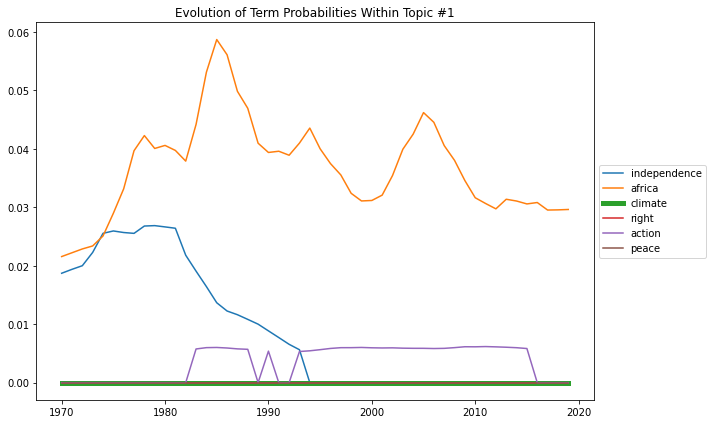

In [90]:
# choose terms of topic 1 that you want to viz. probability evolutions for @Group, QUESTION BY LUC, maybe we can make a function for this?
#................
term1 = 'independence'
term2 = 'africa'
term3 = 'climate'
term4 = 'right'
term5 = 'action'
term6 = 'peace'
#................

# extract term1 probabilities
prob_term1 = []

for col in range(len(df_term_evolution.columns)):
    if df_term_evolution[1970+col].str.contains(term1).any():
        prob_term1.append(df_prob_evolution.iloc[df_term_evolution.loc[df_term_evolution[1970+col] == term1].index[0],col])
    else: 
        prob_term1.append(0.0)
        
# extract term2 probabilities
prob_term2 = []

for col in range(len(df_term_evolution.columns)):
    if df_term_evolution[1970+col].str.contains(term2).any():
        prob_term2.append(df_prob_evolution.iloc[df_term_evolution.loc[df_term_evolution[1970+col] == term2].index[0],col])
    else: 
        prob_term2.append(0.0)
        
# extract term3 probabilities
prob_term3 = []

for col in range(len(df_term_evolution.columns)):
    if df_term_evolution[1970+col].str.contains(term3).any():
        prob_term3.append(df_prob_evolution.iloc[df_term_evolution.loc[df_term_evolution[1970+col] == term3].index[0],col])
    else: 
        prob_term3.append(0.0)
        
# extract term4 probabilities
prob_term4 = []

for col in range(len(df_term_evolution.columns)):
    if df_term_evolution[1970+col].str.contains(term4).any():
        prob_term4.append(df_prob_evolution.iloc[df_term_evolution.loc[df_term_evolution[1970+col] == term4].index[0],col])
    else: 
        prob_term4.append(0.0)
        
# extract term5 probabilities
prob_term5 = []

for col in range(len(df_term_evolution.columns)):
    if df_term_evolution[1970+col].str.contains(term5).any():
        prob_term5.append(df_prob_evolution.iloc[df_term_evolution.loc[df_term_evolution[1970+col] == term5].index[0],col])
    else: 
        prob_term5.append(0.0)
        
# extract term6 probabilities
prob_term6 = []

for col in range(len(df_term_evolution.columns)):
    if df_term_evolution[1970+col].str.contains(term6).any():
        prob_term6.append(df_prob_evolution.iloc[df_term_evolution.loc[df_term_evolution[1970+col] == term6].index[0],col])
    else: 
        prob_term6.append(0.0)
        
        
# Create dataframe in one step
viz_df = pd.DataFrame({term1:prob_term1,
                       term2:prob_term2,
                       term3:prob_term3,
                       term4:prob_term4,
                       term5:prob_term5,
                       term6:prob_term6,})

# transpose dataframe and label years
viz_df = viz_df.T
viz_df.rename(columns = {0: 1970, 1: 1971, 2: 1972, 3: 1973, 4: 1974,
                                         5: 1975,6: 1976, 7: 1977, 8: 1978, 9: 1979, 10: 1980,
                                         11: 1981, 12: 1982, 13: 1983, 14: 1984, 15: 1985,
                                         16: 1986, 17: 1987, 18: 1988, 19: 1989, 20: 1990,
                                        21: 1991, 22: 1992, 23: 1993, 24: 1994,
                                         25: 1995, 26: 1996, 27: 1997, 28: 1998, 29: 1999, 30: 2000,
                                         31: 2001, 32: 2002, 33: 2003, 34: 2004, 35: 2005,
                                         36: 2006, 37: 2007, 38: 2008, 39: 2009, 40: 2010,
                                         41: 2011, 42: 2012, 43: 2013, 44: 2014, 45: 2015,
                                         46: 2016, 47: 2017, 48: 2018, 49: 2019}, 
                        inplace = True)

# plot
ax = viz_df.T.plot(title='Evolution of Term Probabilities Within Topic #1', figsize=(10,6))
ax.get_lines()[-4].set_linewidth(5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.figure.tight_layout()
#plt.show()